In [63]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from timeit import default_timer as timer

from sklearn.metrics import root_mean_squared_error as rsme

device = "cuda" if torch.cuda.is_available() else "cpu"

In [64]:
torch.manual_seed(724)

n, d = 1000, 1
X = torch.randn(n, d)
true_w = torch.arange(1., d+1.).unsqueeze(1)   # shape [d,1]
true_b = 3.0
y = (X @ true_w).squeeze(1) + true_b + 0.5*torch.randn(n)

# train/val split
idx = torch.randperm(n)
tr, va = idx[:800], idx[800:]
Xtr, ytr = X[tr], y[tr]
Xva, yva = X[va], y[va]

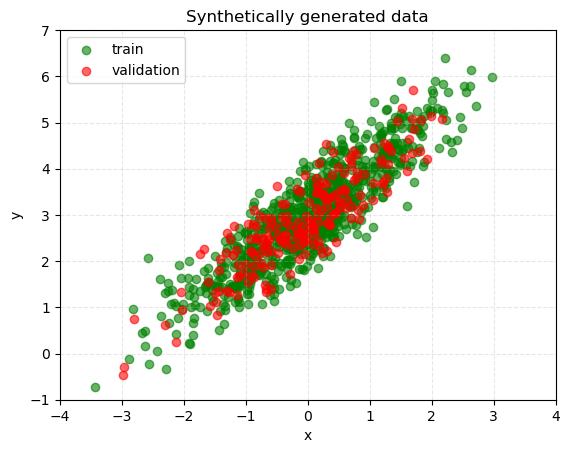

In [81]:
plt.scatter(Xtr, ytr, c='g', alpha=0.6, label='train')
plt.scatter(Xva, yva, c='r', alpha=0.6, label='validation')

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetically generated data")
plt.grid(True, linestyle="--", alpha=0.3)

plt.xlim(-4,4)
plt.ylim(-1,7)

plt.show()

In [66]:
ds_tr = TensorDataset(Xtr, ytr)
ds_va = TensorDataset(Xva, yva)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=ds_tr,
                              batch_size=BATCH_SIZE,
                              shuffle=True,)

test_dataloader = DataLoader(dataset=ds_va,
                              batch_size=BATCH_SIZE,
                              shuffle=False,)

In [67]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # put model in train mode
    model.train()

    # train loss, train accuracy values
    train_loss = 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # forward pass
        # B, _ = X.shape
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y.unsqueeze(dim=1))
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

######################################################################

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # initialize test loss
    test_loss = 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            y = y.to(device)

            # forward pass
            test_pred = model(X)

            # calculate loss
            loss = loss_fn(test_pred, y.unsqueeze(dim=1))
            test_loss += loss.item()
    
    test_loss = test_loss / len(dataloader)
    return test_loss

######################################################################

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "test_loss": [],
               "slope": [model.state_dict()['weight'][0].clone()],
               "intercept": [model.state_dict()['bias'].clone()],}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        if scheduler is not None:
            scheduler.step()
        
        print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Test loss: {test_loss:.4f} ")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)
        results['slope'].append(model.state_dict()['weight'][0].clone())
        results['intercept'].append(model.state_dict()['bias'].clone())

    # return results
    return results

In [68]:
# random seeds
torch.manual_seed(724)
torch.cuda.manual_seed(724)

# training/testing data
ds_tr = TensorDataset(Xtr, ytr)
ds_va = TensorDataset(Xva, yva)



# Create DataLoader's
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=ds_tr,
                              batch_size=BATCH_SIZE,
                              shuffle=True,)

test_dataloader = DataLoader(dataset=ds_va,
                              batch_size=BATCH_SIZE,
                              shuffle=False,)

# number of epochs
NUM_EPOCHS = 50

# model instantiation
model = nn.Linear(1, 1).to(device)

# setup loss function
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

# start timer
start_time = timer()

# train model 0

model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=opt,
                        scheduler=None,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end timer and print
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 13.8407  |  Test loss: 11.0075 
Epoch: 1  |  Train loss: 11.5736  |  Test loss: 9.1922 
Epoch: 2  |  Train loss: 9.5809  |  Test loss: 7.6647 
Epoch: 3  |  Train loss: 7.9044  |  Test loss: 6.3573 
Epoch: 4  |  Train loss: 6.5148  |  Test loss: 5.2337 
Epoch: 5  |  Train loss: 5.3081  |  Test loss: 4.3242 
Epoch: 6  |  Train loss: 4.3388  |  Test loss: 3.5468 
Epoch: 7  |  Train loss: 3.5380  |  Test loss: 2.9000 
Epoch: 8  |  Train loss: 2.8708  |  Test loss: 2.3700 
Epoch: 9  |  Train loss: 2.3328  |  Test loss: 1.9368 
Epoch: 10  |  Train loss: 1.8955  |  Test loss: 1.5824 
Epoch: 11  |  Train loss: 1.5467  |  Test loss: 1.2952 
Epoch: 12  |  Train loss: 1.2617  |  Test loss: 1.0639 
Epoch: 13  |  Train loss: 1.0376  |  Test loss: 0.8768 
Epoch: 14  |  Train loss: 0.8589  |  Test loss: 0.7310 
Epoch: 15  |  Train loss: 0.7191  |  Test loss: 0.6161 
Epoch: 16  |  Train loss: 0.6103  |  Test loss: 0.5252 
Epoch: 17  |  Train loss: 0.5264  |  Test loss: 0.4559 

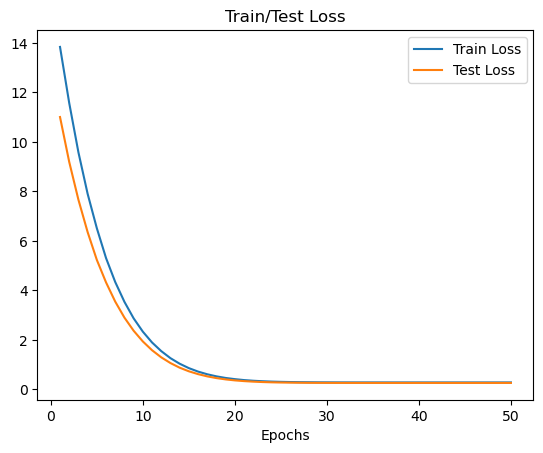

In [69]:
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss"], label="Train Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss"], label="Test Loss")
plt.title("Train/Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

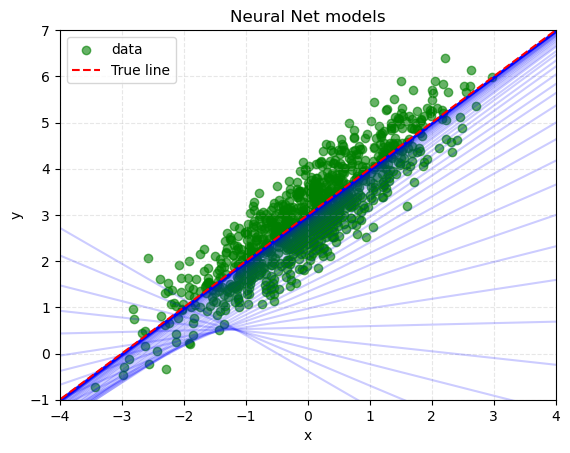

In [80]:
slopes = np.array(model_0_results['slope'])         # list -> array, shape [k]
intercepts = np.array(model_0_results['intercept'])  # list -> array, shape [k]
assert slopes.shape == intercepts.shape

# choose an x-range (change as needed)
x = np.linspace(-5, 5, 200)       # shape [n]

# broadcast to all lines: Y[i, j] = slopes[i]*x[j] + intercepts[i]
Y = slopes[:, None] * x[None, :] + intercepts[:, None]   # shape [k, n]

plt.plot(x, Y.T.squeeze(), alpha=0.2, c='b')       # plot all k lines at once
plt.scatter(Xtr, ytr, c='g', alpha=0.6, label='data')
plt.scatter(Xva, yva, c='g', alpha=0.6)

plt.plot(x, x + true_b, c='r', linestyle='dashed', label='True line')

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Neural Net models")
plt.grid(True, linestyle="--", alpha=0.3)

plt.xlim(-4,4)
plt.ylim(-1,7)

plt.show()

In [71]:
intercepts[-1]

array([2.9789839], dtype=float32)

In [72]:
model1.weight.data.numpy().flatten()

array([-0.1213969 , -0.11998349, -0.36877584, -0.11400712,  0.27950764,
       -0.10598579,  0.10804647, -0.11762199, -0.09553263, -0.37315115,
       -0.42041534, -0.0611074 ,  0.3807506 , -0.00826609,  0.08218014,
        0.42139024,  0.36291593, -0.42936915, -0.02797079,  0.07793123],
      dtype=float32)

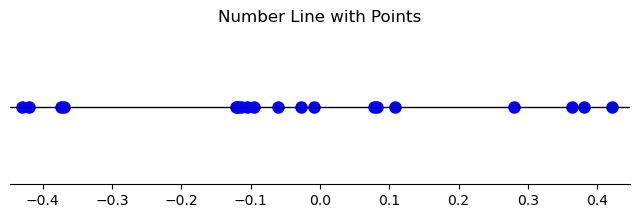

In [73]:
# Define the points you want to plot on the number line
model1 = torch.nn.Linear(in_features=5, out_features=4, bias=True)
points = model1.weight.data.numpy().flatten()

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(8, 2)) # Adjust figsize for better visualization

# Plot the points. We set y-coordinates to 0 to keep them on the number line.
ax.plot(points, np.zeros_like(points), 'o', markersize=8, color='blue') # 'o' for circle marker

# Draw the horizontal line (the number line itself)
ax.axhline(0, color='black', linewidth=1)

# Set x-axis limits to encompass the points and a bit more
ax.set_xlim(-1/np.sqrt(5), 1/np.sqrt(5))

# Remove the y-axis as it's not relevant for a number line
ax.yaxis.set_visible(False)

# Remove spines (borders) except for the bottom one
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add labels to the points (optional)
# for p in points:
#     ax.text(p, 0.1, str(p), ha='center', va='bottom')

# Set the title
ax.set_title("Number Line with Points")

# Display the plot
plt.show()